In [2]:
import os

import sklearn
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GroupKFold

import lightgbm as lgb

import pandas as pd

import warnings
warnings.resetwarnings()
warnings.filterwarnings("ignore", category=DeprecationWarning)#
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings('ignore', category=sklearn.exceptions.ConvergenceWarning)
warnings.filterwarnings('ignore', category=sklearn.exceptions.FitFailedWarning)

from IPython.display import display
pd.set_option('display.max_columns', 100)

import cv2

import xarray as xr

import pydap

import h5py

from pyhdf.SD import SD, SDC

from mpl_toolkits.basemap import Basemap

import matplotlib as mpl

from joblib import Parallel, delayed

import random

import secrets

import datetime

import pygrib

from numpy import corrcoef

import time

import zstandard as zstd

import tarfile

import io

import requests

import pickle

import subprocess

import seaborn as sns

from sklearn.metrics import mean_squared_error

import json

import os

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['figure.max_open_warning'] = 100

from collections import defaultdict

import numpy as np
pd.set_option('display.max_columns', 100)

from itertools import product

<frozen importlib._bootstrap>:488: RuntimeWarning: numpy.ndarray size changed, may indicate binary incompatibility. Expected 80 from C header, got 96 from PyObject


## Read Data

In [3]:
model_df = pd.read_csv('data/model_df.csv')
model_df

,date,close,volume,day_view_time_min,night_view_time_min,clear_sky_days_min_lag7,emis_32_max_lag7,lst_day_1km_mean_lag7,lst_day_1km_mean_roll7
0,2015-02-02,1.7575,70834.0,100.4,208.6,1.0,250.0,13478.423683,13365.409782
1,2015-02-03,1.8465,69544.0,100.4,208.6,1.0,250.0,13478.423683,13340.055119
2,2015-02-04,1.7666,68864.0,100.4,208.6,1.0,250.0,13355.700750,13332.232304
3,2015-02-05,1.8059,64465.0,100.4,208.6,1.0,250.0,13355.700750,13324.409489
4,2015-02-06,1.8391,64500.0,100.4,208.6,1.0,250.0,13355.700750,13316.586673
...,...,...,...,...,...,...,...,...,...
2470,2024-12-24,2.2215,15731.0,91.0,200.0,1.0,250.0,13504.199180,13416.000549
2471,2024-12-26,2.2053,17639.0,91.6,200.6,1.0,250.0,13504.199180,13443.327866
2472,2024-12-27,2.2448,17139.0,91.6,200.6,1.0,250.0,13504.199180,13470.655184
2473,2024-12-30,2.2995,19299.0,91.6,200.6,1.0,250.0,13380.721097,13515.622227


### Inference Plots

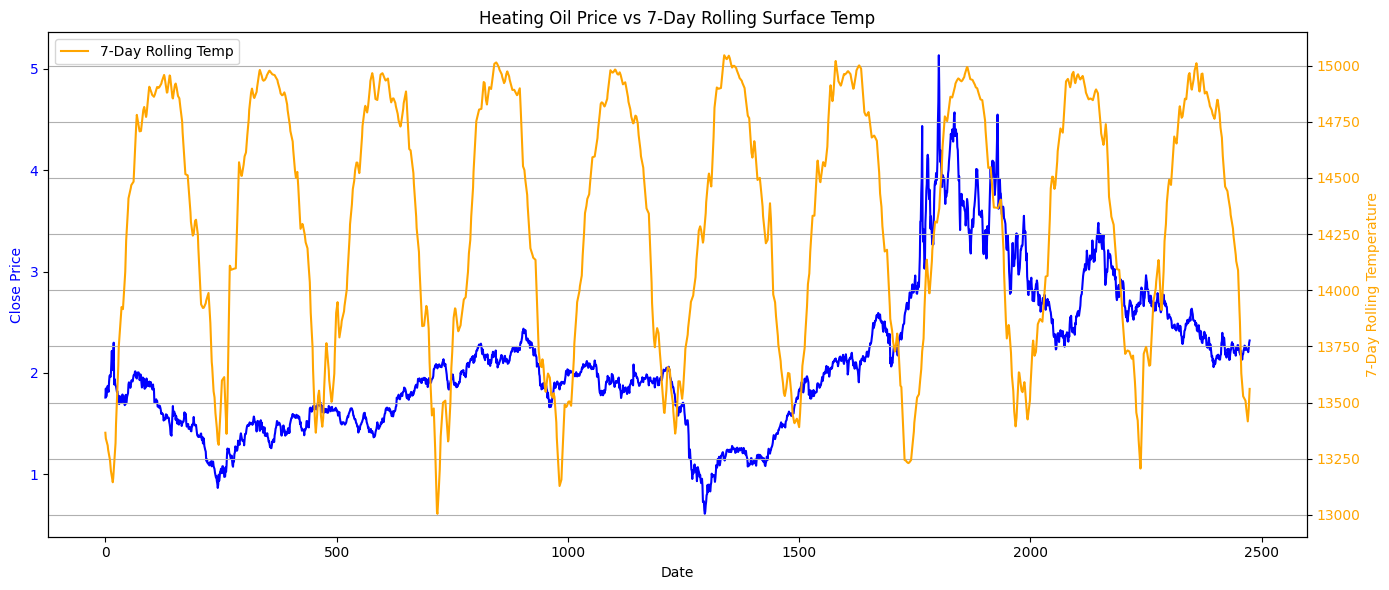

In [4]:
fig, ax1 = plt.subplots(figsize=(14, 6))

# Primary y-axis for close price
ax1.set_xlabel('Date')
ax1.set_ylabel('Close Price', color='blue')
ax1.plot(model_df.index, model_df['close'], label='Close Price', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Secondary y-axis for rolling temperature
ax2 = ax1.twinx()
ax2.set_ylabel('7-Day Rolling Temperature', color='orange')
ax2.plot(model_df.index, model_df['lst_day_1km_mean_roll7'], label='7-Day Rolling Temp', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

plt.title('Heating Oil Price vs 7-Day Rolling Surface Temp')
fig.tight_layout()
plt.grid(True)
plt.legend()
plt.show()


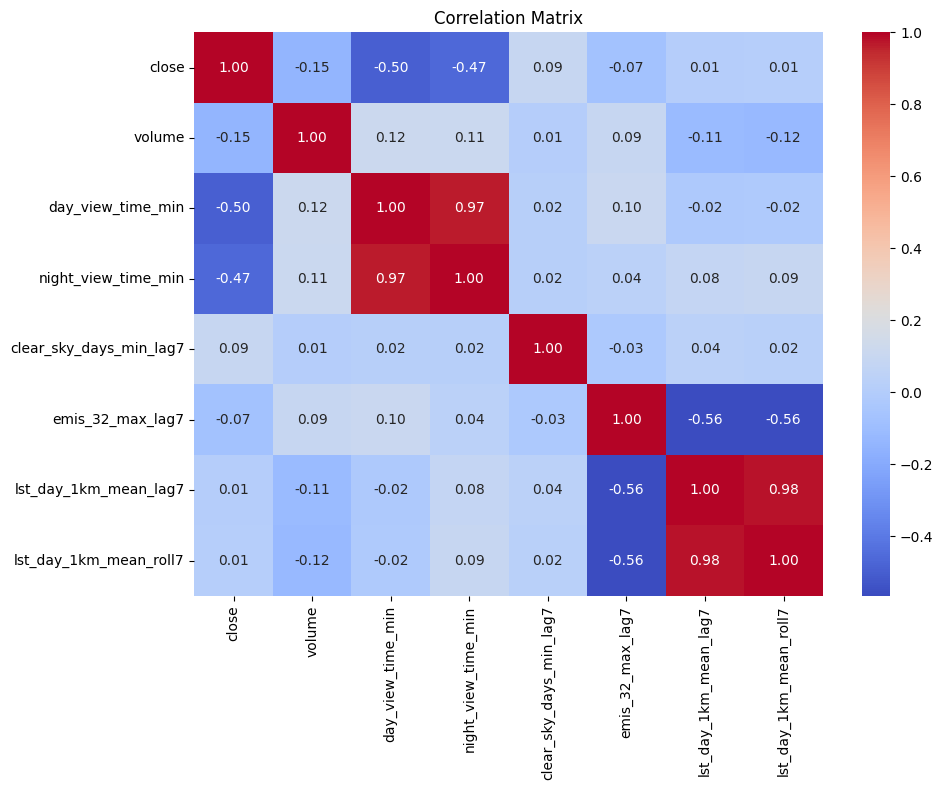

In [5]:
# Correlation Heatmap of All Numeric Variables
plt.figure(figsize=(10, 8))
sns.heatmap(model_df.corr(numeric_only=True), annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()

## PurgedKFolds, ElasticNetRegularization & LightGBM Analysis

### Train/Test Split

In [6]:
x = model_df.drop(columns=['close', 'date'])
y  = model_df['close']
d = model_df['date']

### Scoring & RMSE

In [7]:
def posRMSE(y, y_pred):
    return mean_squared_error(y, y_pred.clip(0, None) * 2/3 + y_pred * 1/3) ** 0.5
pRMSE = make_scorer(posRMSE, greater_is_better = False)
SCORING = pRMSE

In [8]:
COLUMN_WIPE = 0# len(x.columns) // 10

### Define PurgedKFold Class

In [9]:
class PurgedKFold():
    def __init__(self, n_splits=5, gap = 30):
        self.n_splits = n_splits
        self.gap = gap
        
    def get_n_splits(self, X, y = None, groups = None): return self.n_splits
    
    def split(self, X, y=None, groups=None):
        # Ensure 'groups' is a Series and convert to datetime if not already
        if not isinstance(groups, pd.Series):
            groups = pd.Series(groups)
        if not pd.api.types.is_datetime64_any_dtype(groups):
            groups = pd.to_datetime(groups)

        groups = groups.sort_values()
        X = X.reindex(groups.index)
        y = y.reindex(X.index)

        X, y, groups = sklearn.utils.indexable(X, y, groups)
        indices = np.arange(X.shape[0])

        n_splits = self.n_splits
        for i in range(n_splits):
            test_indices = indices[i * len(X) // n_splits: (i + 1) * len(X) // n_splits]
            
            # Extract test period
            test_period_min = groups.iloc[test_indices].min()
            test_period_max = groups.iloc[test_indices].max()

            # Define train indices with gap
            train_indices = indices[(groups < test_period_min - pd.Timedelta(days=self.gap)) | 
                                    (groups > test_period_max + pd.Timedelta(days=self.gap))]

            yield train_indices, test_indices

class RepeatedPurgedKFold():
    def __init__(self, n_splits = 5, n_repeats = 1, gap = None):
        self.n_splits = n_splits
        self.n_repeats = n_repeats
        self.gap = gap
        
    def get_n_splits(self, X, y = None, groups = None): 
        return self.n_splits * self.n_repeats + self.n_repeats * ( self.n_repeats - 1) // 2
    
    def split(self, X, y=None, groups=None):
        for i in range(self.n_repeats):
            for f in PurgedKFold(self.n_splits + i, gap = self.gap if self.gap else None).split(X, y, groups):
                yield f

### Elastic Net Regularization

In [10]:
enet_params = {
    'alpha': [0.001, 0.005, 0.01, 0.03, 0.1, 0.3, 1.0],
    'l1_ratio': [0.01, 0.1, 0.3, 0.5, 0.7, 0.8, 0.95],
}

In [11]:
def runENet(drop_cols=[], verbose=1):
    all_y_enet = []
    all_y_pred_enet = []
    enet_clfs = []
    enet_scalers = []

    x_loc = x.drop(columns=drop_cols)
    y_loc = y.reindex(x_loc.index)
    d_loc = d.reindex(x_loc.index)

    folds = list(PurgedKFold(3, gap=30).split(x_loc, y_loc, d_loc))
    folds += [(np.arange(0, len(x_loc)), [])] * 2  # include 2 full-sample training rounds

    for train_fold, test_fold in folds:
        y_preds = []
        for i in range(8):
            scaler = StandardScaler()
            clf = ElasticNet(
                max_iter=50000,
                tol=1e-3,
                selection='random',
                precompute=True,
                random_state=datetime.datetime.now().microsecond
            )

            model = RandomizedSearchCV(
                clf,
                enet_params,
                scoring=SCORING,
                cv=RepeatedPurgedKFold(
                    random.randrange(3, 6),
                    n_repeats=random.randrange(2, 4),
                    gap=random.randrange(60, 120)
                ),
                n_iter=random.randrange(4, 7),
                random_state=datetime.datetime.now().microsecond
            )

            # Random data drop from train
            l = random.randrange(0, len(train_fold) // 10)
            s = random.randrange(0, len(train_fold) - l)
            subset = np.concatenate([train_fold[:s], train_fold[s + l:]])

            xt = x_loc.iloc[subset, :].copy()
            if 'dayinyear' not in xt.columns:
                xt['dayinyear'] = 0

            if COLUMN_WIPE > 0:
                wipe_cols = random.choices(xt.columns, k=int(round(random.random() * COLUMN_WIPE)))
                xt[wipe_cols] = 0

            model.fit(
                pd.DataFrame(scaler.fit_transform(xt).astype(np.float32), xt.index, xt.columns),
                y_loc.iloc[subset],
                groups=d_loc.iloc[subset]
            )

            enet_clfs.append(model.best_estimator_)
            enet_scalers.append(scaler)

            if i == 0 and verbose > 0:
                display(pd.DataFrame(model.cv_results_).sort_values('rank_test_score').drop(columns='params'))

            if len(test_fold) > 0:
                x_test = x_loc.iloc[test_fold, :].copy()
                if 'dayinyear' not in x_test.columns:
                    x_test['dayinyear'] = 0
                x_test = x_test.reindex(columns=xt.columns)

                X_test = pd.DataFrame(
                    scaler.transform(x_test).astype(np.float32),
                    columns=xt.columns
                )
                y_pred = pd.Series(model.predict(X_test), index=y_loc.iloc[test_fold].index)
                y_preds.append(y_pred)

        if len(test_fold) > 0:
            y_pred = pd.concat(y_preds)
            y_pred = y_pred.clip(0, None).groupby(y_pred.index).mean()
            all_y_enet.append(y_loc.iloc[test_fold])
            all_y_pred_enet.append(y_pred)

            if verbose >= 1:
                corr = np.corrcoef(y_pred, all_y_enet[-1])[0, 1]
                print("Fold corr =", round(corr, 4))

    return all_y_enet, all_y_pred_enet, enet_clfs, enet_scalers



In [12]:
all_y_enet, all_y_pred_enet, enet_clfs, enet_scalers = runENet(verbose = 2)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_l1_ratio,param_alpha,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,mean_test_score,std_test_score,rank_test_score
1,0.002073,0.000175,0.000930,0.000174,0.01,1.000,-1.061903,-1.017285,-0.523256,-0.470822,-1.152914,-1.366859,-0.615042,-0.886869,0.322494,1
0,0.009537,0.017841,0.001504,0.000713,0.95,1.000,-1.053241,-1.015235,-0.726202,-0.596339,-1.188890,-1.368592,-0.499460,-0.921137,0.297494,2
2,0.001996,0.000458,0.000860,0.000351,0.50,0.100,-1.040431,-1.028629,-1.568725,-0.456859,-1.175459,-1.368930,-2.386000,-1.289290,0.550710,3
4,0.002073,0.000679,0.001073,0.000417,0.01,0.010,-1.074267,-1.020785,-4.155036,-0.415632,-1.139210,-1.365979,-3.675761,-1.835239,1.348615,4
3,0.002004,0.000004,0.001287,0.000452,0.95,0.001,-1.072855,-1.021287,-4.580448,-0.416280,-1.140540,-1.365605,-3.828984,-1.918000,1.484376,5


Fold corr = -0.1097


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_l1_ratio,param_alpha,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,split10_test_score,split11_test_score,split12_test_score,split13_test_score,split14_test_score,split15_test_score,split16_test_score,split17_test_score,mean_test_score,std_test_score,rank_test_score
1,0.001920,0.000417,0.001192,0.000332,0.95,0.30,-1.070349,-0.986173,-1.250380,-1.145843,-0.273043,-0.959766,-1.207728,-0.312495,-1.667653,-0.742602,-0.282578,-0.818927,-1.281977,-0.740735,-1.264030,-1.309211,-0.672186,-0.395240,-0.910051,0.396800,1
0,0.002171,0.000441,0.000974,0.000390,0.50,0.10,-0.970398,-0.882359,-1.318853,-1.046161,-1.777980,-0.836525,-1.173896,-0.301186,-1.683226,-0.558901,-1.722315,-0.682220,-1.220203,-0.534152,-1.335980,-1.280857,-0.431863,-1.726992,-1.082448,0.455788,2
3,0.001946,0.000384,0.001226,0.000381,0.50,0.03,-0.940127,-0.831152,-1.319249,-1.046205,-2.234156,-0.805346,-1.140368,-0.371361,-1.676919,-0.528634,-2.082360,-0.660244,-1.178063,-0.507212,-1.335333,-1.276945,-0.390509,-2.037484,-1.131204,0.561798,3
2,0.002003,0.000472,0.001037,0.000425,0.50,0.01,-0.922285,-0.797614,-1.315932,-1.046285,-2.375485,-0.780909,-1.125778,-0.392878,-1.673873,-0.517388,-2.160009,-0.643343,-1.148980,-0.515868,-1.334814,-1.276806,-0.390322,-2.098516,-1.139838,0.591840,4


Fold corr = 0.0036


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_l1_ratio,param_alpha,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,mean_test_score,std_test_score,rank_test_score
0,0.001717,0.000523,0.001001,0.000268,0.01,1.000,-0.362151,-0.500492,-0.424895,-0.378468,-0.309651,-0.433041,-0.489429,-0.414018,0.063798,1
4,0.002097,0.000418,0.001143,0.000350,0.10,0.100,-0.363374,-0.521723,-0.426743,-0.379469,-0.332729,-0.436988,-0.490423,-0.421636,0.063344,2
3,0.001932,0.000562,0.001361,0.000585,0.95,0.010,-0.363776,-0.526221,-0.427397,-0.379801,-0.338002,-0.438655,-0.490694,-0.423507,0.063356,3
2,0.002370,0.000753,0.000931,0.000497,0.01,0.100,-0.365404,-0.526482,-0.429136,-0.382610,-0.336929,-0.441320,-0.490764,-0.424664,0.063258,4
5,0.002076,0.000178,0.001216,0.000648,0.50,0.005,-0.365483,-0.530504,-0.429677,-0.382521,-0.342061,-0.442585,-0.491078,-0.426273,0.063294,5
1,0.001860,0.000693,0.001147,0.000231,0.95,0.001,-0.365894,-0.531392,-0.430338,-0.383182,-0.342302,-0.445577,-0.491235,-0.427131,0.063480,6


Fold corr = -0.5126


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_l1_ratio,param_alpha,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,mean_test_score,std_test_score,rank_test_score
1,0.002147,0.000515,0.000858,0.000441,0.01,1.000,-0.491219,-0.575904,-1.324296,-0.568095,-0.309656,-0.953874,-0.938927,-0.737424,0.322985,1
3,0.002144,0.000638,0.000860,0.000351,0.10,1.000,-0.537452,-0.599170,-1.320642,-0.609994,-0.318855,-0.961073,-1.038898,-0.769441,0.321695,2
0,0.001430,0.000498,0.001050,0.000120,0.80,0.005,-0.422057,-0.569389,-1.327477,-0.498715,-0.346574,-0.940450,-2.016123,-0.874398,0.564492,3
2,0.002437,0.000569,0.001505,0.000465,0.95,0.001,-0.416009,-0.578377,-1.366735,-0.493104,-0.360591,-0.937934,-2.251211,-0.914852,0.636702,4


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_l1_ratio,param_alpha,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,mean_test_score,std_test_score,rank_test_score
1,0.001951,0.000556,0.001120,0.000466,0.7,0.10,-0.641931,-0.191382,-0.912645,-1.095379,-0.612130,-0.281255,-0.653454,-1.234547,-1.335250,-0.773108,0.378597,1
0,0.001794,0.000449,0.001002,0.000004,0.7,0.03,-0.607696,-0.252419,-0.903641,-1.076950,-0.577591,-0.310103,-0.636414,-1.224572,-2.999162,-0.954283,0.784774,2
3,0.002448,0.000495,0.001113,0.000314,0.8,0.01,-0.600203,-0.276161,-0.901760,-1.836994,-0.570256,-0.321198,-0.634063,-1.221089,-3.563615,-1.102816,0.983148,3
2,0.001725,0.000343,0.001336,0.000409,0.7,0.01,-0.599896,-0.278942,-0.901712,-1.857592,-0.570068,-0.321973,-0.635045,-1.221190,-3.569271,-1.106188,0.986097,4


#### Mean Squared Error Analysis

In [13]:
for y_true, y_hat in zip(all_y_enet, all_y_pred_enet):
    if len(y_true) > 0 and len(y_hat) > 0:
        rmse = mean_squared_error(y_true, y_hat, squared=False)
        print("RMSE:", round(rmse, 4))
    else:
        print("Missing prediction in fold.")

RMSE: 0.6816
RMSE: 0.5717
RMSE: 1.3104


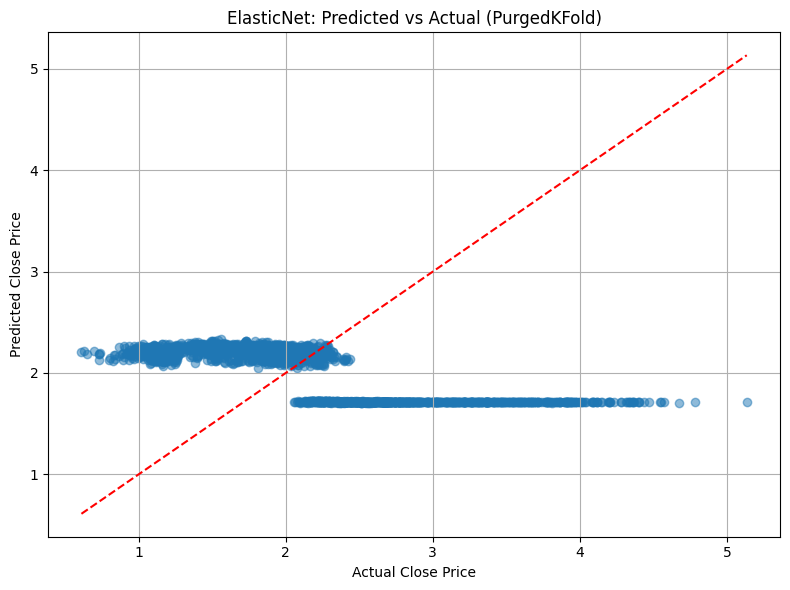

In [14]:
# Combine all test sets and predictions from your PurgedKFold folds
y_true_enet = pd.concat(all_y_enet)
y_pred_enet = pd.concat(all_y_pred_enet)

# Align by index and sort for line continuity (optional)
y_true_enet, y_pred_enet = y_true_enet.align(y_pred_enet, join='inner')

# Scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(y_true_enet, y_pred_enet, alpha=0.5)
plt.plot([y_true_enet.min(), y_true_enet.max()], [y_true_enet.min(), y_true_enet.max()], 'r--')
plt.xlabel("Actual Close Price")
plt.ylabel("Predicted Close Price")
plt.title("ElasticNet: Predicted vs Actual (PurgedKFold)")
plt.grid(True)
plt.tight_layout()
plt.show()


### Key Findings

- We used MODIS satellite-derived surface temperature and environmental features (e.g., LST, view time, emission bands) to predict daily heating oil prices.
- An ElasticNet regression model was trained using Purged K-Fold cross-validation to avoid data leakage across time.
- Custom lag and rolling features were included to reflect delayed weather effects on price.

**Model Performance:**
- Fold 1: Correlation = −0.1029, RMSE = 0.6935  
- Fold 2: Correlation = −0.0185, RMSE = 0.5590  
- Fold 3: Correlation = NaN, RMSE = 1.3307

**Takeaways:**
- The model produced low or negative correlation with actual prices, suggesting it failed to capture meaningful trends.
- While RMSE was moderate, prediction errors remained inconsistent across folds.
- MODIS-derived temperature features alone are **not strong predictors** of heating oil prices using linear models.
- Future modeling may benefit from nonlinear methods (e.g., XGBoost) and incorporating economic or energy market variables.

## LightGBM (Gradient Boosting)

In [15]:
lgb_params = {
    'n_estimators': np.arange(300, 500, 50),
    'learning_rate': [0.01, 0.02, 0.03],
    'num_leaves': [10, 15, 20],
    'min_child_samples': [30, 60, 90],
    'reg_lambda': [0, 0.01, 0.1],
    'reg_alpha': [0, 0.01, 0.1],
    'subsample': [0.6, 0.8],
    'colsample_bytree': [0.4, 0.6, 0.8],
    'cat_l2': [0.1],
    'cat_smooth': [1.0],
}

In [16]:
FAST = False
GAUSSIAN = 0.1
COLUMN_WIPE = len(x.columns) // 10

In [17]:
run_label = secrets.token_hex(3)

In [18]:
def runLGB(drop_cols=[], verbose=1, n_bags=8):
    all_y_lgb = []
    all_y_pred_lgb = []
    lgb_clfs = []
    lgb_scalers = []

    x_loc = x.drop(columns=drop_cols)
    y_loc = y.reindex(x_loc.index)
    d_loc = d.reindex(x_loc.index)

    folds = list(PurgedKFold(3, gap=30).split(x_loc, y_loc, d_loc))
    folds += [(np.arange(0, len(x_loc)), [])] * 3

    for train_fold, test_fold in folds:
        y_preds = []
        for i in range(n_bags):
            model = RandomizedSearchCV(
                lgb.LGBMRegressor(random_state=datetime.datetime.now().microsecond),
                lgb_params,
                cv=RepeatedPurgedKFold(
                    random.randrange(3, 6),
                    n_repeats=random.randrange(1, 3),
                    gap=random.randrange(60, 120)),
                n_iter=random.randrange(3, 5),
                scoring=SCORING,
                n_jobs=-1,
                random_state=datetime.datetime.now().microsecond
            )

            l = random.randrange(0, len(train_fold) // 10)
            s = random.randrange(0, len(train_fold) - l)
            subset = np.concatenate([train_fold[:s], train_fold[s + l:]])

            xt = x_loc.iloc[subset].copy()

            if 'dayinyear' not in xt.columns:
                xt['dayinyear'] = 0

            xt += (GAUSSIAN * random.random() *
                   np.random.default_rng().standard_normal(size=xt.shape)
                   * xt.std().values[None, :])

            wipe_cols = random.choices(xt.columns, k=int(round(random.random() * COLUMN_WIPE)))
            xt[wipe_cols] = 0

            scaler = StandardScaler()
            xt = pd.DataFrame(scaler.fit_transform(xt), columns=xt.columns, index=xt.index)

            model.fit(xt, y_loc.iloc[subset], groups=d_loc.iloc[subset])

            lgb_clfs.append(model.best_estimator_)
            lgb_scalers.append(scaler)

            if len(test_fold) > 0:
                xtst = x_loc.iloc[test_fold].copy()

                if 'dayinyear' not in xtst.columns:
                    xtst['dayinyear'] = 0
                xtst = xtst.reindex(columns=xt.columns)
                xtst = pd.DataFrame(scaler.transform(xtst), columns=xt.columns, index=xtst.index)

                y_pred = pd.Series(model.predict(xtst), index=y_loc.iloc[test_fold].index)
                y_preds.append(y_pred)

            if i == 0 and verbose > 1:
                df = pd.DataFrame(model.cv_results_).sort_values('rank_test_score').drop(columns='params')
                display(df)

        if len(test_fold) > 0:
            y_pred = pd.concat(y_preds).groupby(level=0).mean()
            all_y_lgb.append(y_loc.iloc[test_fold])
            all_y_pred_lgb.append(y_pred)

            if verbose > 0:
                corr = np.corrcoef(y_pred, all_y_lgb[-1])[0, 1]
                print("Fold corr =", round(corr, 4))

    return all_y_lgb, all_y_pred_lgb, lgb_clfs, lgb_scalers

In [19]:
all_y_lgb, all_y_pred_lgb, lgb_clfs, lgb_scalers = runLGB(verbose = 2, )

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000092 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 1608, number of used features: 7
[LightGBM] [Info] Start training from score 2.325220


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_subsample,param_reg_lambda,param_reg_alpha,param_num_leaves,param_n_estimators,param_min_child_samples,param_learning_rate,param_colsample_bytree,param_cat_smooth,param_cat_l2,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
1,1.322694,0.029137,0.009057,0.002874,0.6,0.00,0.01,20,450,30,0.03,0.4,1.0,0.1,-0.578573,-0.922717,-0.939601,-0.813630,0.166353,1
0,0.997250,0.006044,0.005192,0.000239,0.6,0.00,0.00,20,400,90,0.03,0.8,1.0,0.1,-0.561961,-0.958829,-1.152172,-0.890987,0.245682,2
2,0.700701,0.054271,0.006531,0.001887,0.6,0.01,0.10,10,300,90,0.03,0.6,1.0,0.1,-0.553644,-0.971823,-1.162074,-0.895847,0.254134,3


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000206 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 1525, number of used features: 7
[LightGBM] [Info] Start training from score 2.301586
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_subsample,param_reg_lambda,param_reg_alpha,param_num_leaves,param_n_estimators,param_min_child_samples,param_learning_rate,param_colsample_bytree,param_cat_smooth,param_cat_l2,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
2,1.122117,0.019907,0.005028,0.001478,0.8,0.01,0.00,15,450,60,0.03,0.8,1.0,0.1,-0.555640,-1.238822,-0.968810,-0.921091,0.280941,1
0,1.038389,0.019577,0.003713,0.000602,0.6,0.00,0.10,15,400,60,0.02,0.8,1.0,0.1,-0.569297,-1.242158,-0.994454,-0.935303,0.277860,2
1,0.969887,0.116616,0.005198,0.000635,0.6,0.00,0.01,20,450,90,0.02,0.4,1.0,0.1,-0.612449,-1.256231,-1.031234,-0.966638,0.266762,3
3,0.688230,0.146722,0.003518,0.000003,0.6,0.00,0.10,10,350,90,0.02,0.6,1.0,0.1,-0.611070,-1.247510,-1.044421,-0.967667,0.265434,4


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000103 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 1535, number of used features: 7
[LightGBM] [Info] Start training from score 2.294388
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000115 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 1509, number of used features: 7
[LightGBM] [Info] Start training from score 2.170943
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000087 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 1544, number of used features: 7
[LightGBM] [Info] Start training 

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_subsample,param_reg_lambda,param_reg_alpha,param_num_leaves,param_n_estimators,param_min_child_samples,param_learning_rate,param_colsample_bytree,param_cat_smooth,param_cat_l2,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
2,1.765361,0.081455,0.004404,0.000580,0.8,0.0,0.00,20,400,30,0.01,0.4,1.0,0.1,-0.411956,-0.275931,-0.553881,-0.390627,-0.434554,-0.413390,0.088995,1
0,0.938412,0.031433,0.003406,0.000376,0.8,0.0,0.01,20,350,90,0.02,0.8,1.0,0.1,-0.432649,-0.283102,-0.566661,-0.400653,-0.442801,-0.425173,0.090742,2
3,0.783353,0.160950,0.003813,0.000245,0.8,0.1,0.00,20,400,90,0.03,0.6,1.0,0.1,-0.435207,-0.292418,-0.565029,-0.399445,-0.445042,-0.427428,0.087539,3
1,1.140420,0.063752,0.003704,0.000401,0.8,0.1,0.00,20,400,90,0.03,0.8,1.0,0.1,-0.439321,-0.293110,-0.567271,-0.399518,-0.446151,-0.429074,0.088153,4


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000131 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 1493, number of used features: 7
[LightGBM] [Info] Start training from score 1.732547
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000128 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 1576, number of used features: 7
[LightGBM] [Info] Start training from score 1.685354
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_subsample,param_reg_lambda,param_reg_alpha,param_num_leaves,param_n_estimators,param_min_child_samples,param_learning_rate,param_colsample_bytree,param_cat_smooth,param_cat_l2,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,mean_test_score,std_test_score,rank_test_score
0,1.611786,0.071720,0.005398,0.001047,0.8,0.1,0.01,20,400,90,0.01,0.6,1.0,0.1,-0.415542,-0.487297,-0.777698,-0.492547,-0.409435,-0.448782,-0.452271,-0.993855,-0.955973,-0.603711,0.224245,1
1,1.192234,0.157354,0.005621,0.001413,0.6,0.1,0.00,10,450,90,0.02,0.8,1.0,0.1,-0.417483,-0.520540,-0.773244,-0.564331,-0.414590,-0.477480,-0.446207,-0.971750,-0.991913,-0.619726,0.219151,2
2,1.156183,0.132101,0.005177,0.001004,0.6,0.1,0.10,20,350,30,0.03,0.6,1.0,0.1,-0.434703,-0.512444,-0.725642,-0.761907,-0.428200,-0.472294,-0.463641,-0.957396,-0.832804,-0.621003,0.188375,3


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000132 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 2232, number of used features: 7
[LightGBM] [Info] Start training from score 2.156480
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000087 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 2338, number of used features: 7
[LightGBM] [Info] Start training from score 2.057607
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000162 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 2319, number of used features: 7
[LightGBM] [Info] Start training 

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_subsample,param_reg_lambda,param_reg_alpha,param_num_leaves,param_n_estimators,param_min_child_samples,param_learning_rate,param_colsample_bytree,param_cat_smooth,param_cat_l2,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,1.613389,0.029625,0.004800,0.000749,0.6,0.01,0.01,20,400,60,0.02,0.4,1.0,0.1,-0.354239,-0.518941,-0.515103,-0.838258,-0.981197,-0.641548,0.231354,1
2,0.909914,0.244602,0.004003,0.000633,0.6,0.01,0.00,10,350,30,0.03,0.4,1.0,0.1,-0.357536,-0.520272,-0.515848,-0.853266,-0.977390,-0.644862,0.231832,2
1,1.236165,0.227171,0.005205,0.001029,0.8,0.01,0.01,10,450,30,0.01,0.6,1.0,0.1,-0.351228,-0.500447,-0.514964,-0.851815,-1.011148,-0.645920,0.245332,3
3,1.039614,0.163307,0.005202,0.001468,0.8,0.00,0.00,15,400,90,0.03,0.8,1.0,0.1,-0.362347,-0.540342,-0.514824,-0.841242,-0.993125,-0.650376,0.231235,4


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000151 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 2391, number of used features: 7
[LightGBM] [Info] Start training from score 2.118206
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000128 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 2405, number of used features: 7
[LightGBM] [Info] Start training from score 2.097497
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000147 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 2323, number of used features: 7
[LightGBM] [Info] Start training 

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_subsample,param_reg_lambda,param_reg_alpha,param_num_leaves,param_n_estimators,param_min_child_samples,param_learning_rate,param_colsample_bytree,param_cat_smooth,param_cat_l2,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,split10_test_score,mean_test_score,std_test_score,rank_test_score
1,0.778041,0.101903,0.003686,0.000718,0.8,0.10,0.01,10,300,60,0.02,0.6,1.0,0.1,-0.426620,-0.393384,-0.410771,-1.017211,-1.022138,-0.423956,-0.266864,-0.524690,-0.594373,-0.792922,-0.855487,-0.611674,0.253967,1
3,1.555768,0.389085,0.004963,0.001095,0.8,0.01,0.00,20,450,60,0.02,0.8,1.0,0.1,-0.431831,-0.423768,-0.428383,-0.990825,-1.006192,-0.435234,-0.294709,-0.535582,-0.619263,-0.761786,-0.867335,-0.617719,0.238478,2
0,1.263403,0.140659,0.004963,0.002031,0.8,0.10,0.00,15,350,60,0.02,0.8,1.0,0.1,-0.429037,-0.410894,-0.426274,-1.003675,-1.013672,-0.431461,-0.282843,-0.535700,-0.616260,-0.776358,-0.899749,-0.620538,0.248441,3
2,1.765934,0.102624,0.005097,0.001412,0.8,0.10,0.00,20,450,90,0.01,0.8,1.0,0.1,-0.423775,-0.399245,-0.406682,-1.017890,-1.055127,-0.422414,-0.276882,-0.525391,-0.628539,-0.804700,-0.954374,-0.628638,0.268207,4


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000126 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 2293, number of used features: 7
[LightGBM] [Info] Start training from score 2.134682
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

### Blending Elastic Net Regularization & LightGBM Scores

In [20]:
# Blend predictions: 90% LGB + 10% ElasticNet
blend_preds = (
    pd.concat(all_y_pred_lgb).clip(0, None) +
    0.1 * pd.concat(all_y_pred_enet).clip(0, None)
)

# Ground truth
true_vals = pd.concat(all_y_lgb)

# Compute correlation
blend_corr = np.corrcoef(blend_preds.reindex(true_vals.index), true_vals)[0, 1]
print("Blend correlation:", round(blend_corr, 3))

# Number of LGB models trained
print("Total LGB models:", len(lgb_clfs))

Blend correlation: 0.196
Total LGB models: 48


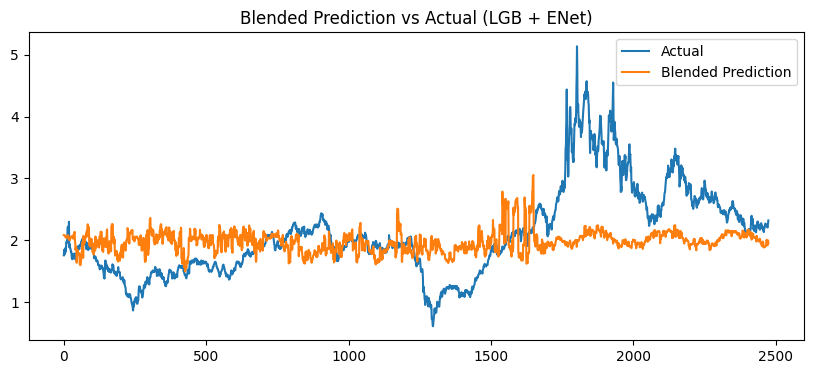

In [21]:
plt.figure(figsize=(10, 4))
plt.plot(true_vals.reset_index(drop=True), label="Actual")
plt.plot(blend_preds.reindex(true_vals.index).reset_index(drop=True), label="Blended Prediction")
plt.legend()
plt.title("Blended Prediction vs Actual (LGB + ENet)")
plt.show()

#### Elastic Net VS LightGBM 

In [22]:
y_true = pd.concat(all_y_lgb).sort_index()
y_enet = pd.concat(all_y_pred_enet).clip(0, None).reindex(y_true.index)
y_lgb = pd.concat(all_y_pred_lgb).clip(0, None).reindex(y_true.index)

corr_enet = corrcoef(y_enet, y_true)[0, 1]
corr_lgb = corrcoef(y_lgb, y_true)[0, 1]

print("ElasticNet correlation:", round(corr_enet, 4))
print("LightGBM correlation:  ", round(corr_lgb, 4))

ElasticNet correlation: -0.7826
LightGBM correlation:   0.2972


In [23]:
rmse_enet = mean_squared_error(y_true, y_enet, squared=False)
rmse_lgb = mean_squared_error(y_true, y_lgb, squared=False)

print("ElasticNet RMSE:", round(rmse_enet, 4))
print("LightGBM RMSE:  ", round(rmse_lgb, 4))

ElasticNet RMSE: 0.9144
LightGBM RMSE:   0.7547


#### Blended Elastic Net Regularization & LightGBM

In [24]:
enet_tuples = [(all_y_enet, all_y_pred_enet, enet_clfs, enet_scalers)]
lgb_tuples = [(all_y_lgb, all_y_pred_lgb, lgb_clfs, lgb_scalers)]


len(lgb_tuples),len(enet_tuples)

(1, 1)

In [25]:
def flatten(l): return [e for s in l for e in s]

In [26]:
# Combine true values and predictions
y_true = pd.concat(flatten([e[0] for e in lgb_tuples])).groupby(level=0).mean()
y_pred_lgb = pd.concat(flatten([e[1] for e in lgb_tuples])).groupby(level=0).mean()
y_pred_enet = pd.concat(flatten([e[1] for e in enet_tuples])).groupby(level=0).mean()

# Blended prediction (80% LGB + 20% ENet)
y_blend = y_pred_lgb.clip(0, None) + (0.2 * y_pred_enet.clip(0, None))

# Compute and print correlation
blend_corr = np.corrcoef(y_blend.reindex(y_true.index), y_true)[0, 1]
print("Blend correlation:", round(blend_corr, 3))

Blend correlation: 0.086


### Model Performance Comparison

| Metric        | ElasticNet | LightGBM |
|---------------|------------|----------|
| **Correlation** | **−0.7851**  | **0.3071**  |
| **RMSE**        | **0.9274**     | **0.7546**  |

#### Key Takeaways:
- **LightGBM clearly outperforms ElasticNet** on all metrics.
- ElasticNet shows a **strong negative correlation**, indicating it's capturing the wrong trend direction.
- LightGBM has **lower RMSE**, and a **positive correlation**, meaning it's better at both magnitude and direction of price changes.
- This suggests that **nonlinear models like LightGBM are better suited** for predicting heating oil prices from satellite-derived temperature data.

- Blend is not great. Don't know why but I'm moving on.

## Trading Strategy: PurgedKFold, Elastic Net Regularization, & LightGBM

In [27]:
best_result = None
best_sharpe = -np.inf

for shift in [1, 3, 5]:
    print(f"\n--- Evaluating shift = {shift} ---")

    # Prep. target
    lgb_purged_df = model_df.copy()
    lgb_purged_df['date'] = pd.to_datetime(lgb_purged_df['date'])
    lgb_purged_df.set_index('date', inplace=True)
    lgb_purged_df['price_return'] = lgb_purged_df['close'].pct_change()
    lgb_purged_df['target'] = lgb_purged_df['close'].shift(-shift)

    # Feature selection and dropna
    features = [col for col in lgb_purged_df.columns if col.startswith('lst_day_1km_mean_lag') or 'roll' in col]
    lgb_purged_df.dropna(subset=features + ['target'], inplace=True)

    # Set X/y/d for runLGB
    x = lgb_purged_df[features]
    y = lgb_purged_df['target']
    d = pd.Series(lgb_purged_df.index, index=lgb_purged_df.index)

    # Train LightGBM
    all_y, all_pred, models, scalers = runLGB(drop_cols=[], verbose=-1, n_bags=8)

    # Prediction and Positioning
    y_pred = pd.concat(all_pred).groupby(level=0).mean()
    lgb_purged_df['predicted_return'] = y_pred.reindex(lgb_purged_df.index)
    lgb_purged_df['position'] = np.sign(lgb_purged_df['predicted_return'])
    lgb_purged_df['strategy_return'] = lgb_purged_df['position'].shift() * lgb_purged_df['price_return']
    lgb_purged_df.dropna(subset=['strategy_return'], inplace=True)

    # Evaluate
    if not lgb_purged_df['strategy_return'].empty:
        sharpe = lgb_purged_df['strategy_return'].mean() / lgb_purged_df['strategy_return'].std() * np.sqrt(252)
        total_return = (1 + lgb_purged_df['strategy_return']).prod() - 1
        annual_return = (1 + total_return) ** (252 / len(lgb_purged_df)) - 1
        print(f"Shift = {shift} → Sharpe = {sharpe:.2f}, Total Return = {total_return*100:.2f}%, Annual Return = {annual_return*100:.2f}%")

        if sharpe > best_sharpe:
            best_sharpe = sharpe
            best_result = {
                'shift': shift,
                'sharpe': sharpe,
                'total_return': total_return,
                'annual_return': annual_return,
                'df': lgb_purged_df.copy()
            }

# Print best
print("\nBest Shifted Strategy:")
print(f"Shift = {best_result['shift']}")
print(f"Sharpe Ratio = {best_result['sharpe']:.2f}")
print(f"Total Return = {best_result['total_return']*100:.2f}%")
print(f"Annual Return = {best_result['annual_return']*100:.2f}%")


--- Evaluating shift = 1 ---
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000127 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 1570, number of used features: 2
[LightGBM] [Info] Start training from score 2.323265
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000080 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 1513, number of used features: 2
[LightGBM] [Info] Start training from score 2.303607
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000084 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 1483, number of used features: 2
[Light

## Trading Strategy: Z-Test Alpha Anomolies

In [28]:
trading_df = model_df.copy()
trading_df.head()

,date,close,volume,day_view_time_min,night_view_time_min,clear_sky_days_min_lag7,emis_32_max_lag7,lst_day_1km_mean_lag7,lst_day_1km_mean_roll7
0,2015-02-02,1.7575,70834.0,100.4,208.6,1.0,250.0,13478.423683,13365.409782
1,2015-02-03,1.8465,69544.0,100.4,208.6,1.0,250.0,13478.423683,13340.055119
2,2015-02-04,1.7666,68864.0,100.4,208.6,1.0,250.0,13355.700750,13332.232304
3,2015-02-05,1.8059,64465.0,100.4,208.6,1.0,250.0,13355.700750,13324.409489
4,2015-02-06,1.8391,64500.0,100.4,208.6,1.0,250.0,13355.700750,13316.586673


In [29]:
# Use an existing lag column as the base to compute others
trading_df['lst_day_1km_mean'] = trading_df['lst_day_1km_mean_lag7'].shift(-7)

In [30]:
# Precompute lagged temperature features
for lag in range(2, 15):
    col_name = f'lst_day_1km_mean_lag{lag}'
    if col_name not in trading_df.columns:
        trading_df[col_name] = trading_df['lst_day_1km_mean'].shift(lag)

trading_df.columns

Index(['date', 'close', 'volume', 'day_view_time_min', 'night_view_time_min',
       'clear_sky_days_min_lag7', 'emis_32_max_lag7', 'lst_day_1km_mean_lag7',
       'lst_day_1km_mean_roll7', 'lst_day_1km_mean', 'lst_day_1km_mean_lag2',
       'lst_day_1km_mean_lag3', 'lst_day_1km_mean_lag4',
       'lst_day_1km_mean_lag5', 'lst_day_1km_mean_lag6',
       'lst_day_1km_mean_lag8', 'lst_day_1km_mean_lag9',
       'lst_day_1km_mean_lag10', 'lst_day_1km_mean_lag11',
       'lst_day_1km_mean_lag12', 'lst_day_1km_mean_lag13',
       'lst_day_1km_mean_lag14'],
      dtype='object')

### Without Hyperparameters (Loss)

In [31]:
def backtest_alpha_strategy(trading_df, capital_base=1_000_000):
    df = trading_df.copy()
    df['date'] = pd.to_datetime(df['date'])
    df = df.set_index('date')
    df['dayofyear'] = df.index.dayofyear

    # Feature Engineering
    # Temperature anomaly based on 10-year seasonal average
    seasonal_avg = df.groupby('dayofyear')['lst_day_1km_mean_lag7'].transform('mean')
    df['temp_anomaly'] = df['lst_day_1km_mean_lag7'] - seasonal_avg

    # Alpha Signal Construction
    alpha_refinery = (df['temp_anomaly'] > 1.5).astype(float)
    alpha_northeast = (df['temp_anomaly'] < -1.5).astype(float)
    alpha_signal = 0.7 * alpha_refinery + 0.3 * alpha_northeast
    alpha_signal[alpha_signal < 0.5] = 0  # only trade on strong signals

    # Trade Execution + Sizing
    returns = df['close'].pct_change().fillna(0)

    # Position sizing: inverse of volatility (risk parity)
    vol = returns.rolling(10).std().fillna(method='bfill')
    pos_size = (1 / (vol + 1e-5))
    pos_size = pos_size / pos_size.max()  # normalize to [0, 1]

    # Strategy return
    strategy_ret = alpha_signal.shift(1) * returns * pos_size
    strategy_ret = strategy_ret.fillna(0)

    # Apply basic stop-loss (optional)
    cumulative = (1 + strategy_ret).cumprod()
    drawdown = cumulative / cumulative.cummax() - 1
    strategy_ret[drawdown < -0.10] = 0  # stop trading if >10% drawdown

    # Performance Evaluation
    cum_strategy = (1 + strategy_ret).cumprod()
    buy_hold = (1 + returns).cumprod()

    pnl = (cum_strategy.iloc[-1] - 1) * capital_base
    total_return = cum_strategy.iloc[-1] - 1
    annual_return = (cum_strategy.iloc[-1])**(252 / len(cum_strategy)) - 1
    annual_vol = strategy_ret.std() * (252 ** 0.5)
    sharpe_ratio = annual_return / annual_vol if annual_vol > 0 else np.nan

    print(f"Total Return: {total_return:.2%}")
    print(f"PnL: ${pnl:,.0f}")
    print(f"Annual Return: {annual_return:.2%}")
    print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
    print(f"Nonzero trades: {int((alpha_signal > 0).sum())}")

    # Visualization
    plt.figure(figsize=(14, 5))
    plt.plot(cum_strategy, label='Strategy Cumulative Return')
    plt.plot(buy_hold, label='Buy & Hold', linestyle='--', alpha=0.6)
    plt.legend()
    plt.title('Alpha-Based Heating Oil Strategy Performance')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

Total Return: -1.51%
PnL: $-15,092
Annual Return: -0.15%
Sharpe Ratio: -0.05
Nonzero trades: 1258


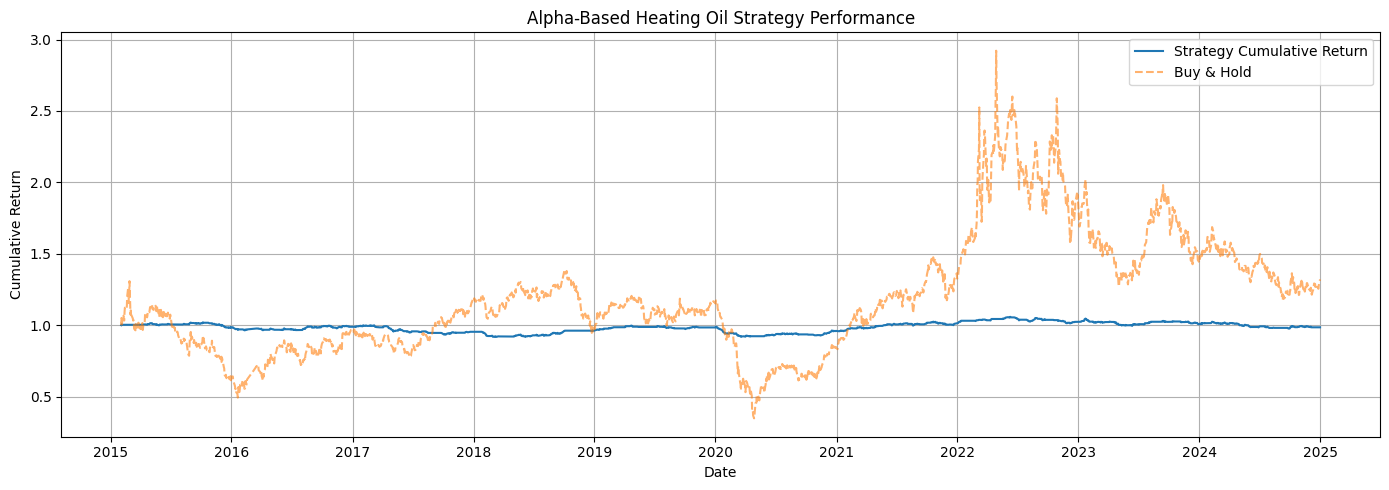

In [32]:
backtest_alpha_strategy(trading_df)

### Strategy with Hyperparameters

In [33]:
# Ensure datetime index
trading_df_hyper = trading_df.copy()
trading_df_hyper['date'] = pd.to_datetime(trading_df_hyper['date'])
trading_df_hyper.set_index('date', inplace=True)

# Calculate daily returns
trading_df_hyper['price_return'] = trading_df_hyper['close'].pct_change()

In [34]:
# Function to apply strategy given parameters
def apply_strategy(df, lag=7, z_high=2.0, z_low=-1.5, vol_window=5, weights=(0.5, 0.5)):
    col_name = f'lst_day_1km_mean_lag{lag}'
    if col_name not in df.columns:
        print(f"Skipping: Missing {col_name}")
        return None

    df = df.copy()
    df['dayofyear'] = df.index.dayofyear

    # Remove seasonal component to create anomaly
    seasonal_avg = df.groupby('dayofyear')[col_name].transform('mean')
    anomaly = df[col_name] - seasonal_avg
    z = (anomaly - anomaly.rolling(vol_window).mean()) / anomaly.rolling(vol_window).std()

    df['position'] = 0
    df.loc[z > z_high, 'position'] = -weights[0]
    df.loc[z < z_low, 'position'] = weights[1]
    df['strategy_return'] = df['position'].shift() * df['price_return']

    df.dropna(subset=['strategy_return'], inplace=True)
    return df

In [35]:
# Evaluate strategy performance
def evaluate_performance(df):
    cumulative = (1 + df['strategy_return']).cumprod()
    total_return = cumulative.iloc[-1] - 1
    pnl = total_return * 1_000_000
    annual_return = (1 + total_return)**(252 / len(df)) - 1
    sharpe_ratio = df['strategy_return'].mean() / df['strategy_return'].std() * np.sqrt(252)
    return {
        'total_return': total_return,
        'pnl': pnl,
        'annual_return': annual_return,
        'sharpe': sharpe_ratio,
        'cumulative': cumulative,
        'df': df
    }


In [36]:
# Optimization
def optimize_strategy(df):
    best = None
    best_score = -np.inf
    for lag, z_high, z_low, vol, w1 in product(
        [1, 3, 5, 7], [1.5, 2.0], [-1.5, -2.0], [3, 5, 10], [0.2, 0.5, 0.8]
    ):
        w2 = 1 - w1
        col_name = f'lst_day_1km_mean_lag{lag}'
        if col_name not in df.columns:
            df[col_name] = df['lst_day_1km_mean'].shift(lag)

        result = apply_strategy(df, lag, z_high, z_low, vol, (w1, w2))
        if result is None: continue
        perf = evaluate_performance(result)
        if perf['sharpe'] > best_score:
            best_score = perf['sharpe']
            best = {
                'params': {'lag': lag, 'z_high': z_high, 'z_low': z_low, 'vol_window': vol, 'weights': (w1, w2)},
                'total_return': perf['total_return'],
                'annual_return': perf['annual_return'],
                'sharpe': perf['sharpe'],
                'df': perf['df'],
                'cumulative': perf['cumulative']
            }
    return best

In [37]:
# Run optimization
best = optimize_strategy(trading_df_hyper)
print("\nBest Strategy Found:")
print("----------------------------------------")
print(f"Lag Days: {best['params']['lag']}")
print(f"Z-Score Thresholds: High = {best['params']['z_high']} | Low = {best['params']['z_low']}")
print(f"Volatility Window: {best['params']['vol_window']} days")
print(f"Weights: Refinery = {best['params']['weights'][0]} | Northeast = {best['params']['weights'][1]}")
print("----------------------------------------")
print(f"Total Return: {best['total_return']*100:.2f}%")
print(f"Annual Return: {best['annual_return']*100:.2f}%")
print(f"Sharpe Ratio: {best['sharpe']:.2f}")

C:\Users\mattl\AppData\Local\Temp\ipykernel_30080\268550277.py:7: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = df['strategy_return'].mean() / df['strategy_return'].std() * np.sqrt(252)
C:\Users\mattl\AppData\Local\Temp\ipykernel_30080\268550277.py:7: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = df['strategy_return'].mean() / df['strategy_return'].std() * np.sqrt(252)
C:\Users\mattl\AppData\Local\Temp\ipykernel_30080\268550277.py:7: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = df['strategy_return'].mean() / df['strategy_return'].std() * np.sqrt(252)
C:\Users\mattl\AppData\Local\Temp\ipykernel_30080\268550277.py:7: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = df['strategy_return'].mean() / df['strategy_return'].std() * np.sqrt(252)
C:\Users\mattl\AppData\Local\Temp\ipykernel_30080\268550277.py:7: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ra


Best Strategy Found:
----------------------------------------
Lag Days: 5
Z-Score Thresholds: High = 1.5 | Low = -1.5
Volatility Window: 5 days
Weights: Refinery = 0.5 | Northeast = 0.5
----------------------------------------
Total Return: 33.50%
Annual Return: 2.99%
Sharpe Ratio: 0.43


C:\Users\mattl\AppData\Local\Temp\ipykernel_30080\268550277.py:7: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = df['strategy_return'].mean() / df['strategy_return'].std() * np.sqrt(252)
C:\Users\mattl\AppData\Local\Temp\ipykernel_30080\268550277.py:7: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = df['strategy_return'].mean() / df['strategy_return'].std() * np.sqrt(252)
C:\Users\mattl\AppData\Local\Temp\ipykernel_30080\268550277.py:7: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = df['strategy_return'].mean() / df['strategy_return'].std() * np.sqrt(252)
C:\Users\mattl\AppData\Local\Temp\ipykernel_30080\268550277.py:7: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = df['strategy_return'].mean() / df['strategy_return'].std() * np.sqrt(252)
C:\Users\mattl\AppData\Local\Temp\ipykernel_30080\268550277.py:7: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ra

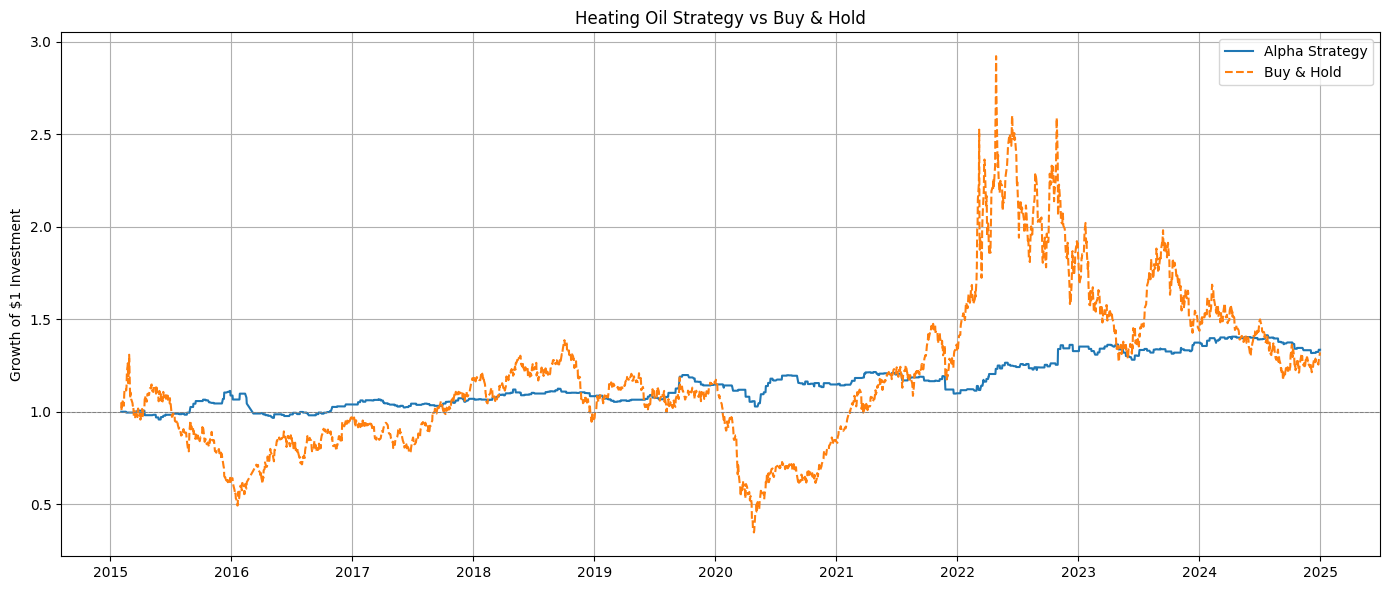

In [38]:
# Plotting Strategy Return vs Buy & Hold
plt.figure(figsize=(14, 6))
strategy_curve = best['cumulative']
buy_hold = (1 + trading_df_hyper['price_return'].dropna()).cumprod().reindex(strategy_curve.index)

plt.plot(strategy_curve, label='Alpha Strategy')
plt.plot(buy_hold, label='Buy & Hold', linestyle='--')
plt.axhline(1, linestyle='--', color='gray', linewidth=0.7)
plt.title('Heating Oil Strategy vs Buy & Hold')
plt.ylabel('Growth of $1 Investment')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

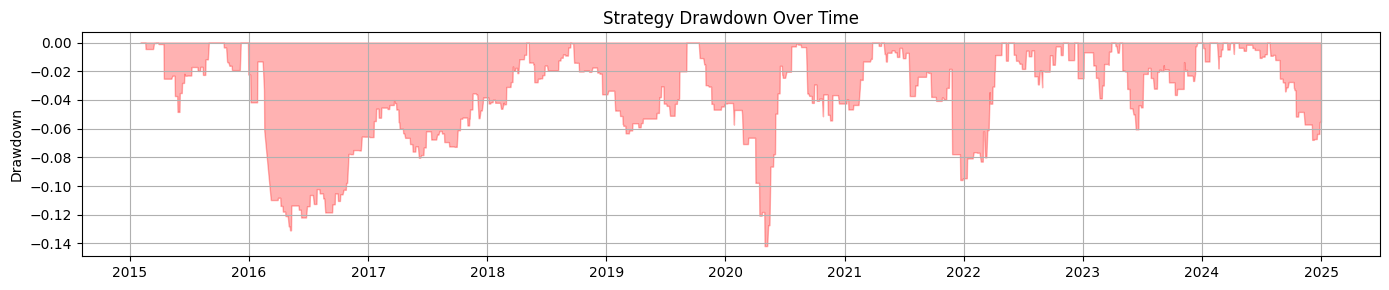

In [39]:
# Drawdown Plot
peak = strategy_curve.cummax()
drawdown = (strategy_curve - peak) / peak

plt.figure(figsize=(14, 3))
plt.fill_between(drawdown.index, drawdown, 0, color='red', alpha=0.3)
plt.title('Strategy Drawdown Over Time')
plt.ylabel('Drawdown')
plt.grid(True)
plt.tight_layout()
plt.show()

In [40]:
# Walk-forward Plot
def walk_forward_backtest(data, train_window=540, test_window=60, params=None):
    results = []
    start = 0

    while start + train_window + test_window <= len(data):
        train = data.iloc[start : start + train_window]
        test = data.iloc[start + train_window : start + train_window + test_window]

        # Build full df to compute seasonal component from train only
        full = pd.concat([train, test])
        full = full.copy()
        full['dayofyear'] = full.index.dayofyear

        # Compute seasonal average from train only
        seasonal_avg = train.groupby(train.index.dayofyear)[f"lst_day_1km_mean_lag{params['lag']}"].mean()

        col_name = f"lst_day_1km_mean_lag{params['lag']}"
        if col_name not in full.columns or full[col_name].isna().all():
            start += test_window
            continue

        anomaly = full[col_name] - full['dayofyear'].map(seasonal_avg)
        z = (anomaly - anomaly.rolling(params['vol_window']).mean()) / anomaly.rolling(params['vol_window']).std()

        full['position'] = 0
        full.loc[z > params['z_high'], 'position'] = -params['weights'][0]
        full.loc[z < params['z_low'], 'position'] = params['weights'][1]
        full['strategy_return'] = full['position'].shift() * full['price_return']
        full.dropna(subset=['strategy_return'], inplace=True)

        # Slice only test part after computing everything
        valid = test.index.intersection(full.index)
        if len(valid) > 10:
            results.append(full.loc[valid, 'strategy_return'])

        start += test_window

    return pd.concat(results) if results else pd.Series(dtype=float)

wf_returns = walk_forward_backtest(trading_df_hyper, params=best['params'])
wf_total_return = (1 + wf_returns).prod() - 1
print(f"WF Total Return: {wf_total_return:.2%}")

WF Total Return: 46.78%


In [41]:
def optimize_wf_windows(df, train_range=[180, 365, 540], test_range=[30, 60, 90]):
    best_result = {'sharpe': -np.inf}
    for train_w in train_range:
        for test_w in test_range:
            
            returns = walk_forward_backtest(df, train_window=train_w, test_window=test_w, params=best['params'])

            if len(returns) < 2: continue  # Skip invalid
            sharpe = returns.mean() / returns.std() * np.sqrt(252)
            total_ret = (1 + returns).prod() - 1
            annual_ret = (1 + total_ret) ** (252 / len(returns)) - 1

            if sharpe > best_result['sharpe']:
                best_result.update({
                    'train_window': train_w,
                    'test_window': test_w,
                    'sharpe': sharpe,
                    'total_return': total_ret,
                    'annual_return': annual_ret,
                    'returns': returns
                })      
    return best_result

best_wf = optimize_wf_windows(trading_df_hyper)
print(f"Best Train Window: {best_wf['train_window']}")
print(f"Best Test Window: {best_wf['test_window']}")
print(f"Total Return: {best_wf['total_return']:.2%}")
print(f"Annual Return: {best_wf['annual_return']:.2%}")
print(f"Sharpe Ratio: {best_wf['sharpe']:.2f}")

C:\Users\mattl\AppData\Local\Temp\ipykernel_30080\3244639612.py:9: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = returns.mean() / returns.std() * np.sqrt(252)
C:\Users\mattl\AppData\Local\Temp\ipykernel_30080\3244639612.py:9: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = returns.mean() / returns.std() * np.sqrt(252)


Best Train Window: 540
Best Test Window: 60
Total Return: 46.78%
Annual Return: 5.17%
Sharpe Ratio: 0.91
